# Alzheimer prediction using gray matter density from T1w MRI

## Giovanni Benedetti da Rosa

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 45.1 MB/s eta 0:00:00


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas
    y = data['y'] # classes, 0 for controls and 1 for patients
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS

In [3]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


In [4]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

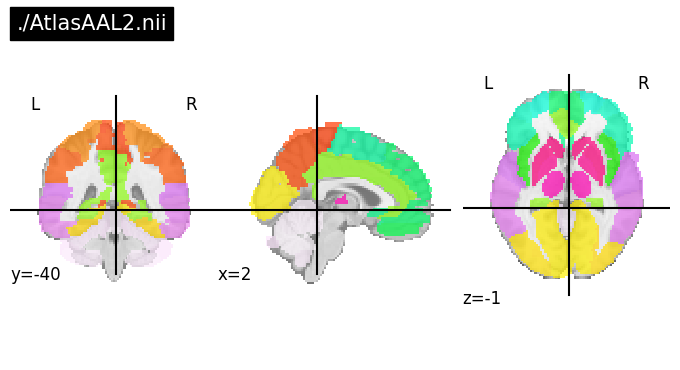

In [5]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [6]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used.

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training.

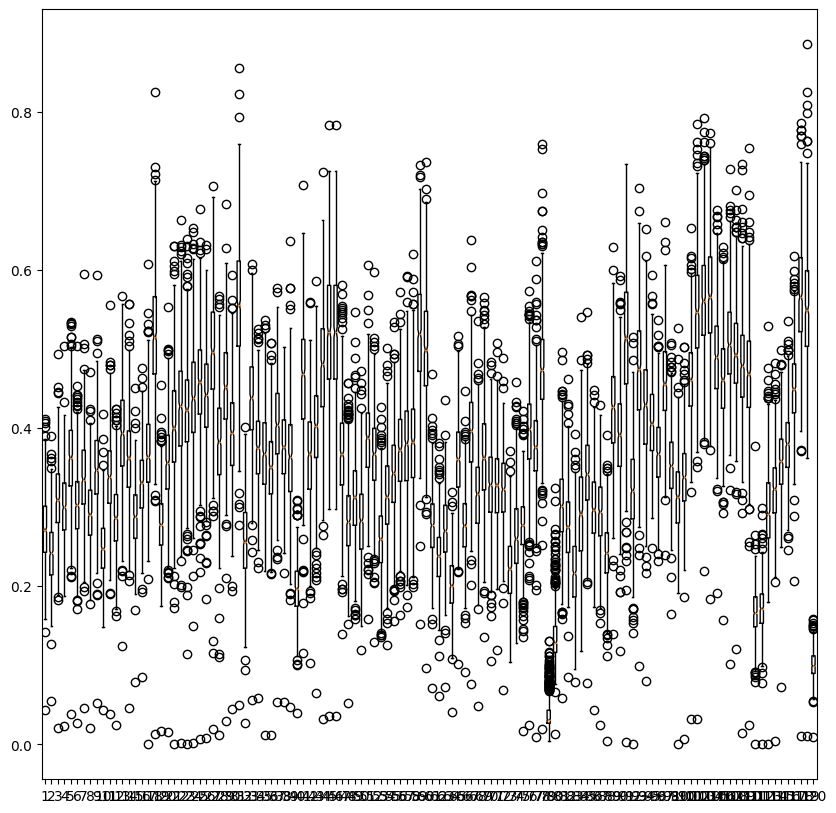

In [7]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

# Standardization/Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalize data (each feature will be scaled into the range 0,1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Then, we can fit a Decision tree, with the default setting, using the following code:

In [8]:
# Fitting Decision Trees
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7654867256637168


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ?
**Answer:**

As we can see below, when we are changing the ```min_samples_split```, overall the values do not change that much, and we found that the bets value for the unseen data(test set) is equal to 5.


Something similar happens with ```min_samples_leaf```, but the best value found was 9.

When we change the values  `random_state` the results change a little bit but, in average maintain the same behavior.



The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  5


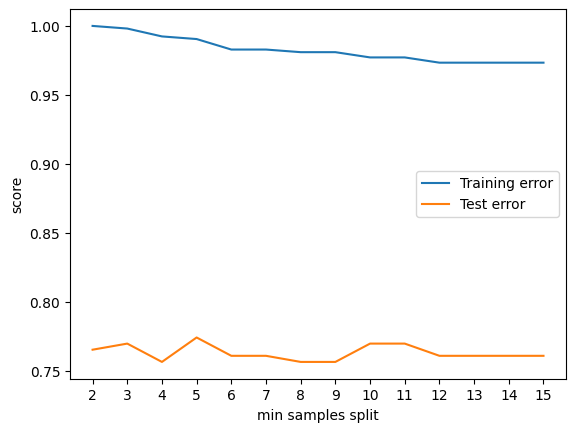

In [9]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  9


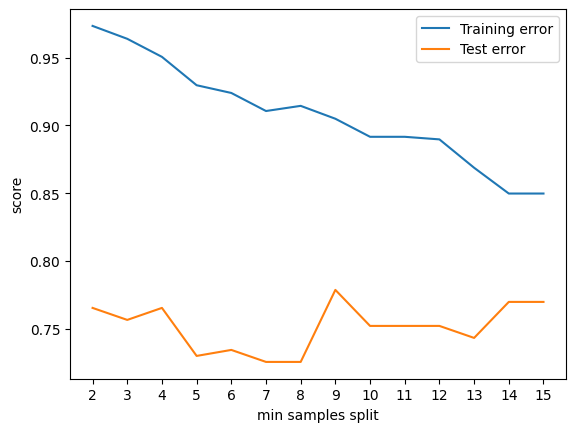

In [10]:
# min_samples_leaf

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();


Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise.

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer**: As expeceted the graph is not stable once the decision tree by essence are sensitive to noise due to the sequantial structure of choosing the bests splits.

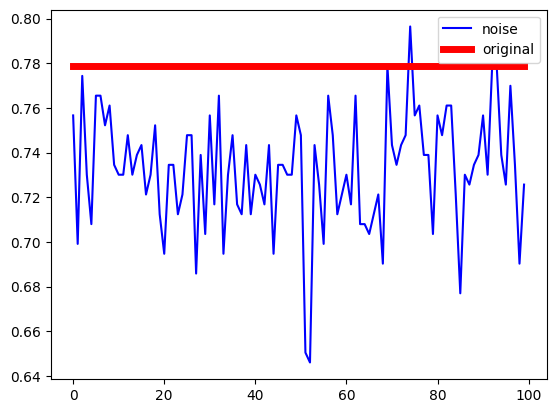

In [11]:
Tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=9,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train, y_train)
scoreTest[:] = Tree.score(X_test, y_test)

for k in range(100):
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] += abs(np.random.normal(0,0.05))

    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)

plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')
plt.legend();

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*.


First plot the tree learnt on the original data, witout adding noise.

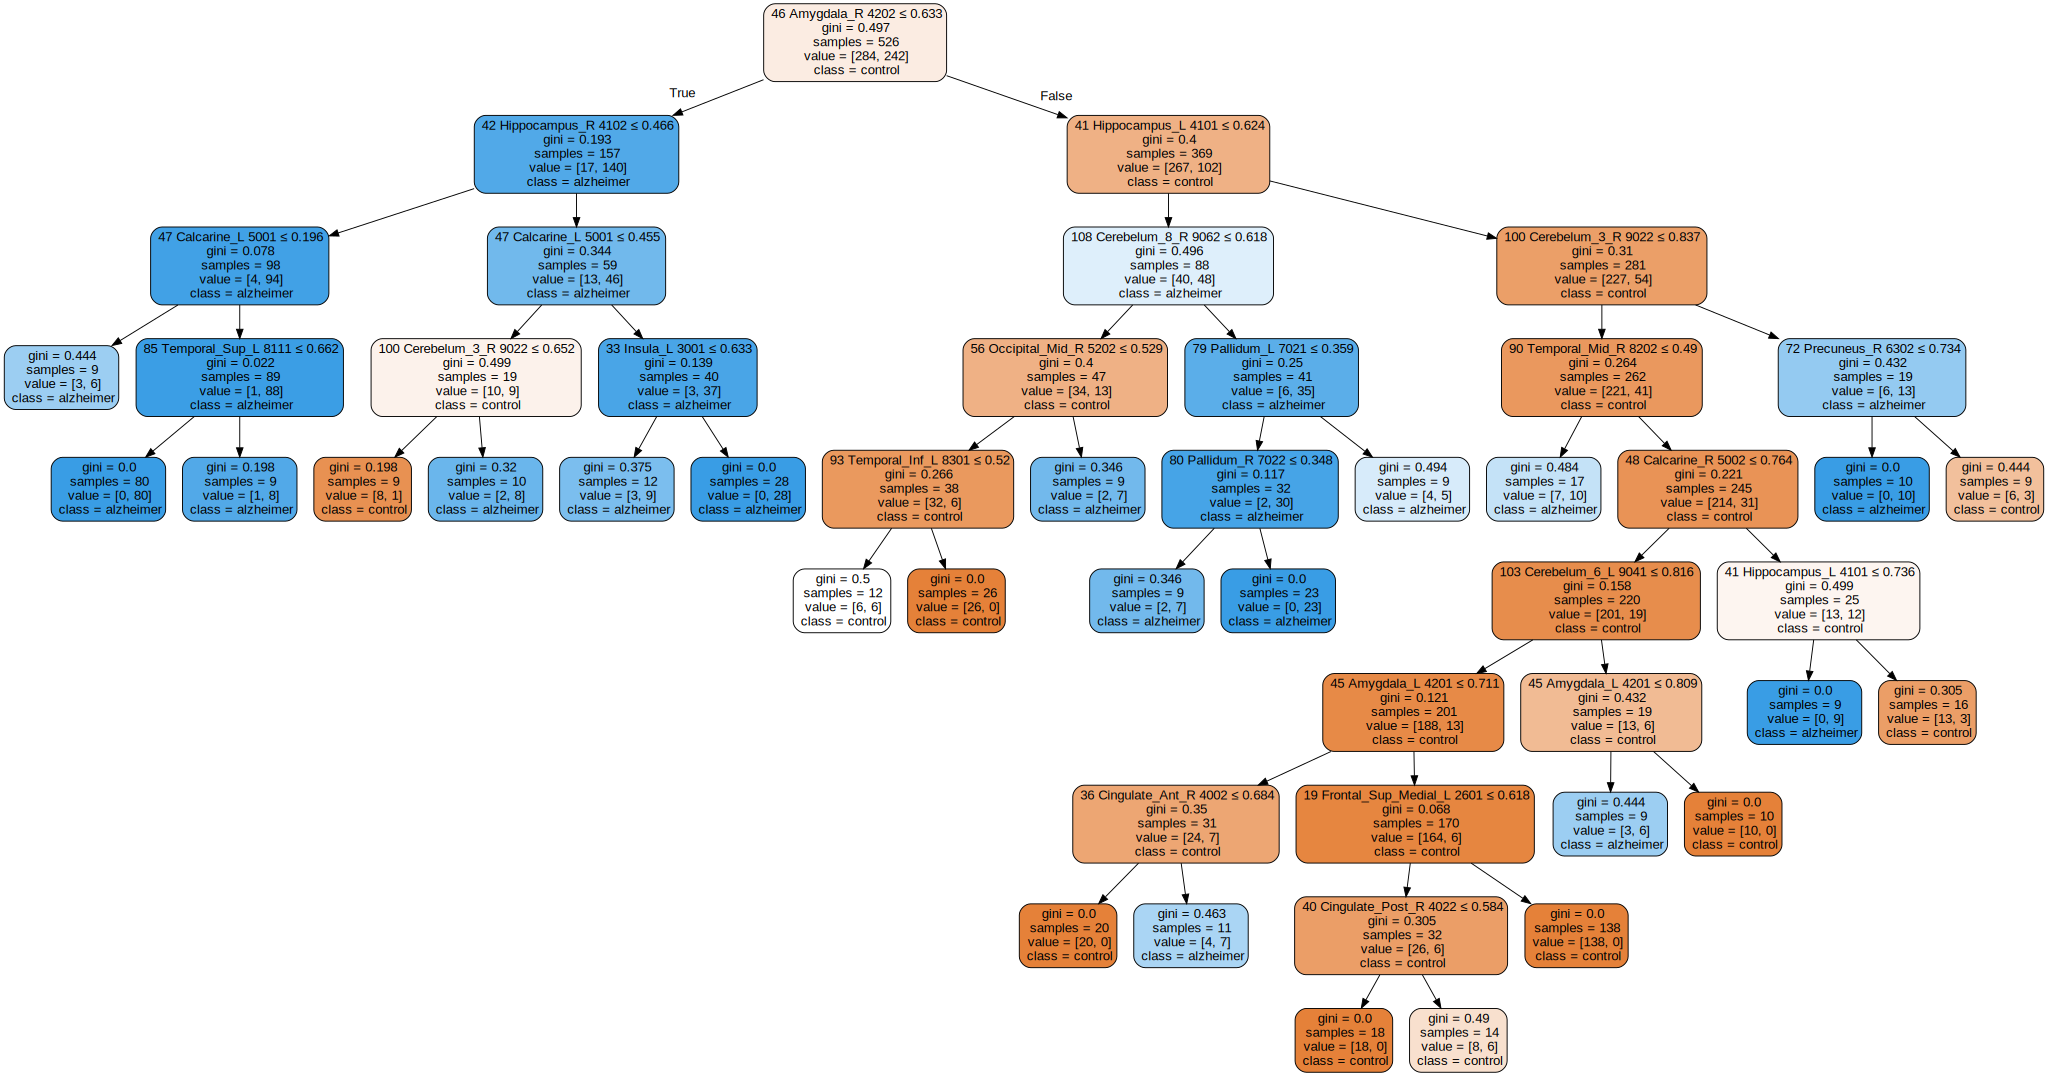

In [13]:
import graphviz

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph


Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer**: No, the results are cleraly not the same. This can show the sensibility of a decision tree.

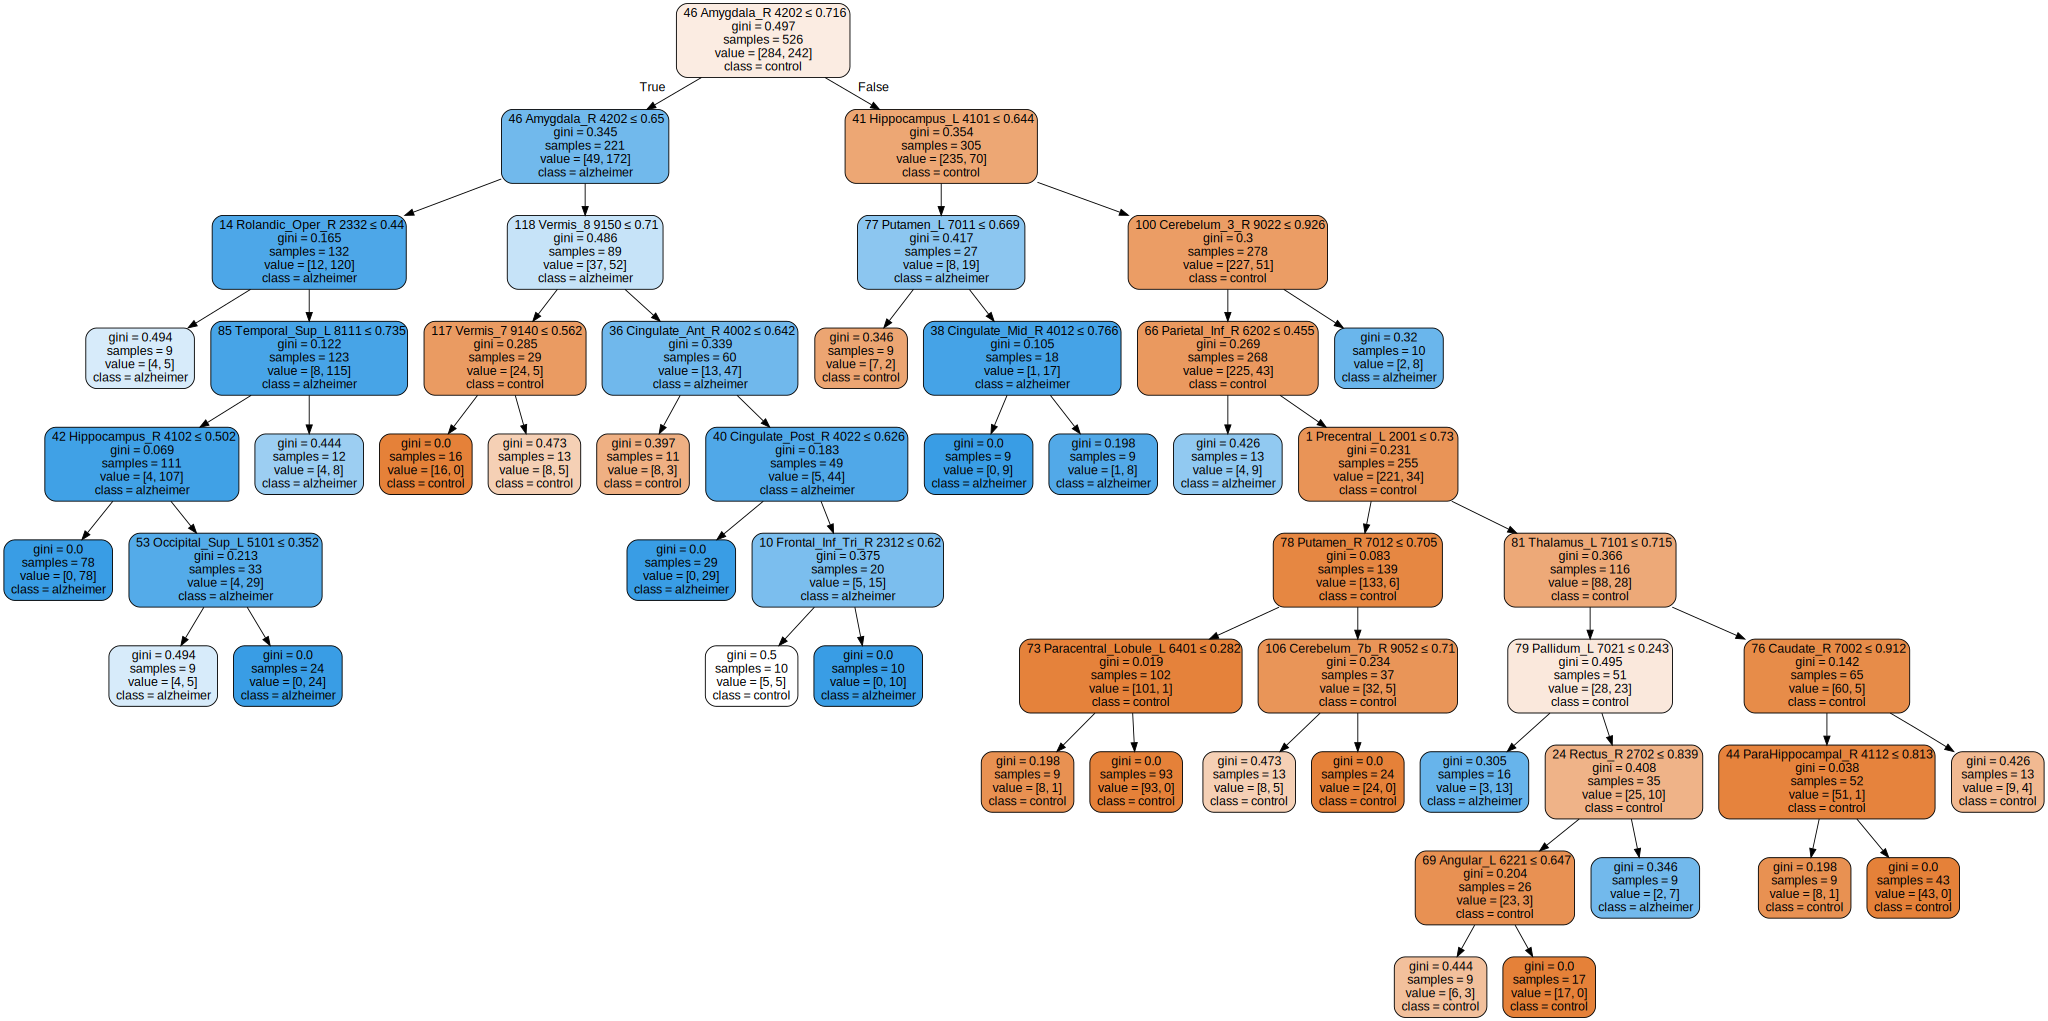

In [14]:
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way.

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Answer**:No, we have not find the same hyperparameters, because before we were keeping as the value that maximized the test score, fixing value for one of the hyperparemeters while varying the other. Here we check the minimum value of the train score beetween all the possible combinations value of the hyperparameters.

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer**: Yes, I would use a different one because the accuracy is not the best score for medical applications once it measures the proportion of correct classifications, and do not take into account the False negatives, so the f1 metric would be a better option.

In [17]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {'min_samples_split': np.arange(2, 16), 'min_samples_leaf': np.arange(2, 16)}
grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, cv=5, scoring='f1')
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7632560440463407
Best params: {'min_samples_leaf': 10, 'min_samples_split': 2}
Tree test score : 0.7083333333333333


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library.

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer**: It's not exactly the same as before, but some ROIs are the same, pointing out the importance of this ROIs for the the prediction proceess.

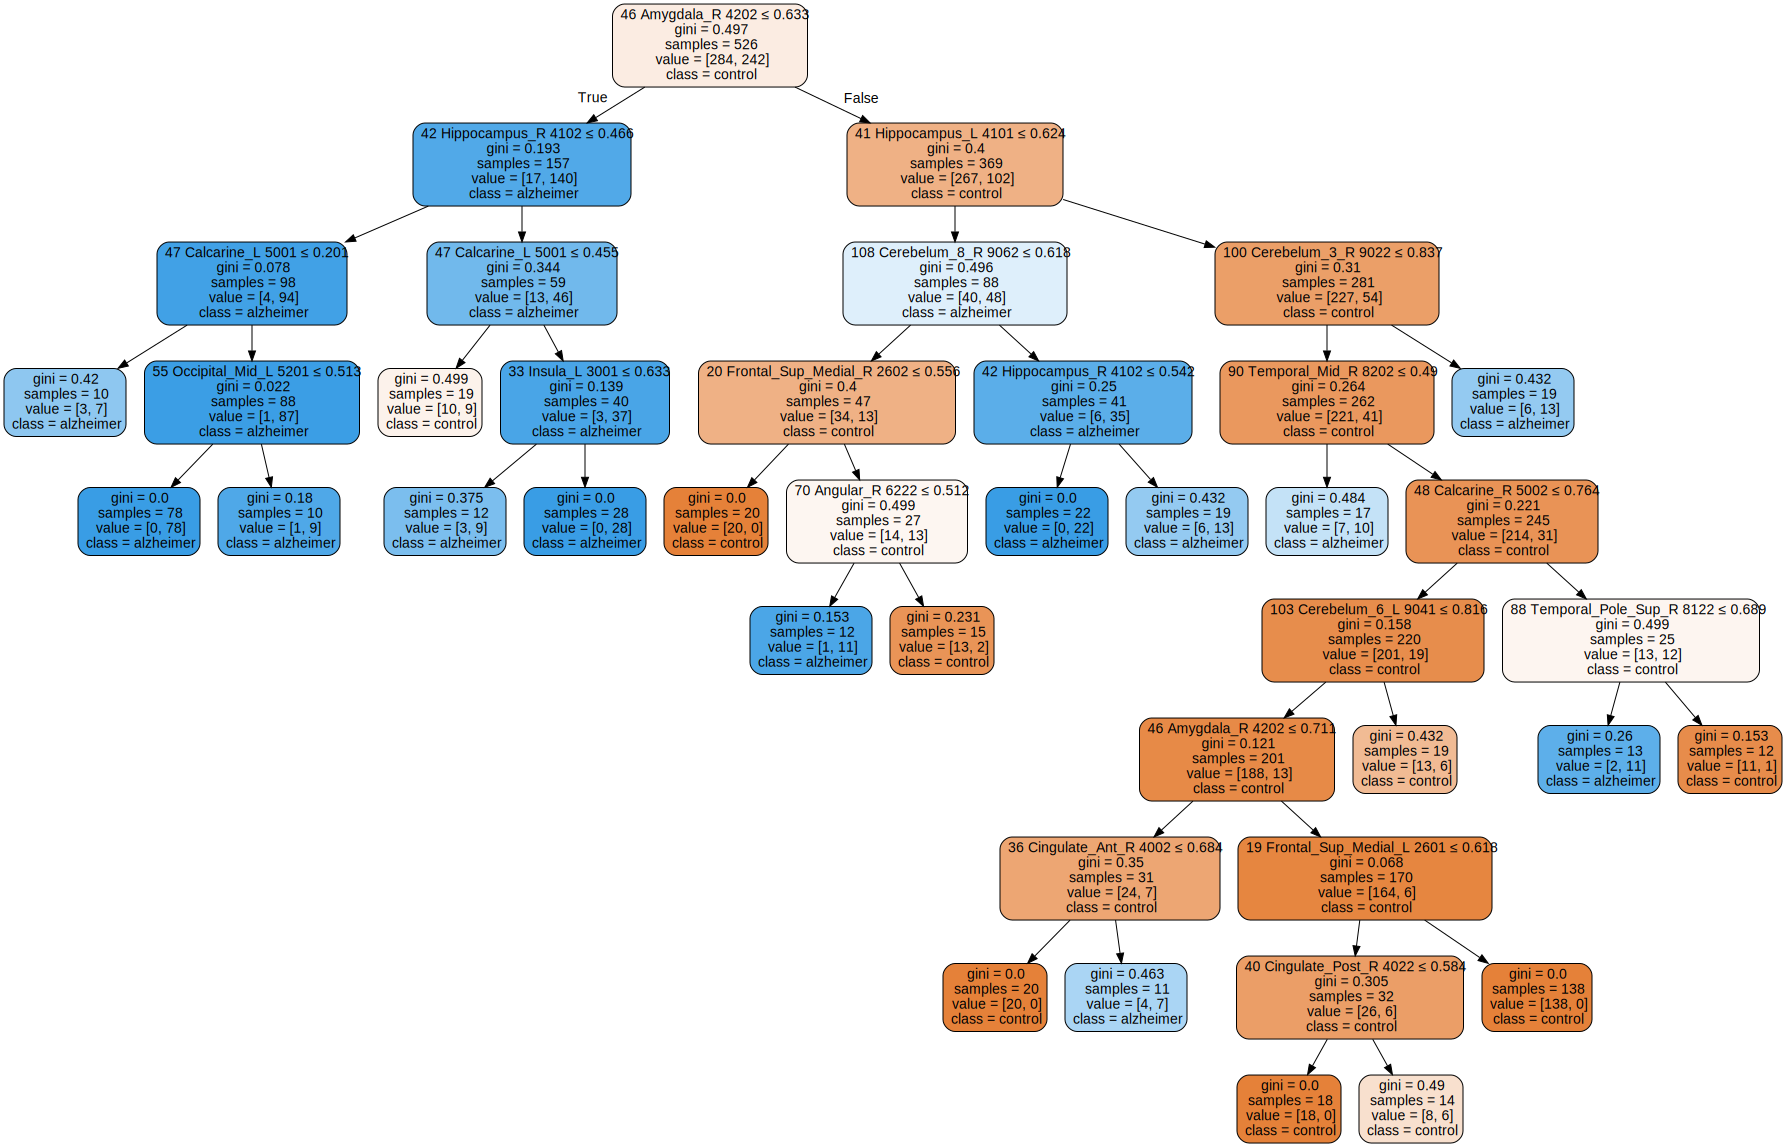

In [18]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'.

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ?

**Answer**: Now, both(original and noisy) have achieved better scores, this can be explained by the  Condorcet's Jury theorem, where if we combine several moderaletely correct classifiers($ p > 0.5$), the majority votring can find a better score.

In [21]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5,scoring="accuracy")
grid_bagging.fit(X_train,y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarnin

Best Validation Score: 0.8192632524707996
Best params: {'n_estimators': 20}
Bagging test score : 0.8097345132743363


In [24]:
# Bagging on noisy data

Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5,scoring="accuracy")
grid_bagging.fit(X_train_temp,y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarnin

Best Validation Score: 0.8079245283018868
Best params: {'n_estimators': 20}
Bagging test score : 0.8097345132743363


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [25]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Validation Score: 0.8173584905660378
Best params: {'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 30}
Random Forest test score : 0.8097345132743363


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging.

In [26]:
# Random Forest on noisy data
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train_temp, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Validation Score: 0.8193710691823899
Best params: {'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 20}
Random Forest test score : 0.8008849557522124


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


We can also use Random Forests to check the importance of the features

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.092777)
2. feature 44 representing 45 Amygdala_L 4201
 (0.075658)
3. feature 41 representing 42 Hippocampus_R 4102
 (0.053680)
4. feature 43 representing 44 ParaHippocampal_R 4112
 (0.045045)
5. feature 40 representing 41 Hippocampus_L 4101
 (0.043823)
6. feature 92 representing 93 Temporal_Inf_L 8301
 (0.040020)
7. feature 93 representing 94 Temporal_Inf_R 8302
 (0.033016)
8. feature 69 representing 70 Angular_R 6222
 (0.021834)
9. feature 42 representing 43 ParaHippocampal_L 4111
 (0.020714)
10. feature 59 representing 60 Fusiform_R 5402
 (0.019888)


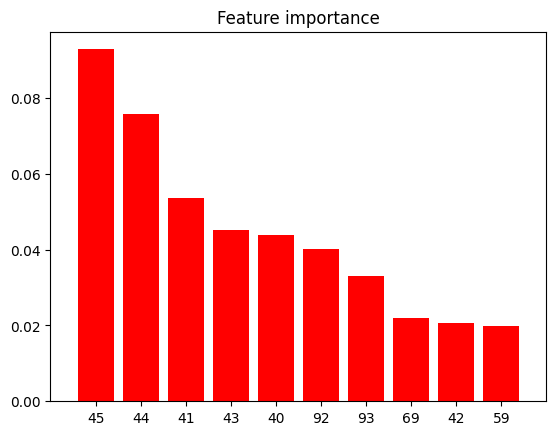

In [ ]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense.

**Answer**:
The top five most importants ROIs are:
* Amygdala R

* Amygdala L

*  Hippocampus_R

* ParaHippocampal_R

* Hippocampus_L

In both papers the amygdalas and the hyppocampus are highleted to be ROIs in identifying the disease. So we can conclude that our results are consistent with the literature.





We can also inspect the data using only pairs of the most important features

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\giova\AppData\Local\Temp\ipykernel_24504\3244815994.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\giova\AppData\Local\Temp\ipyke

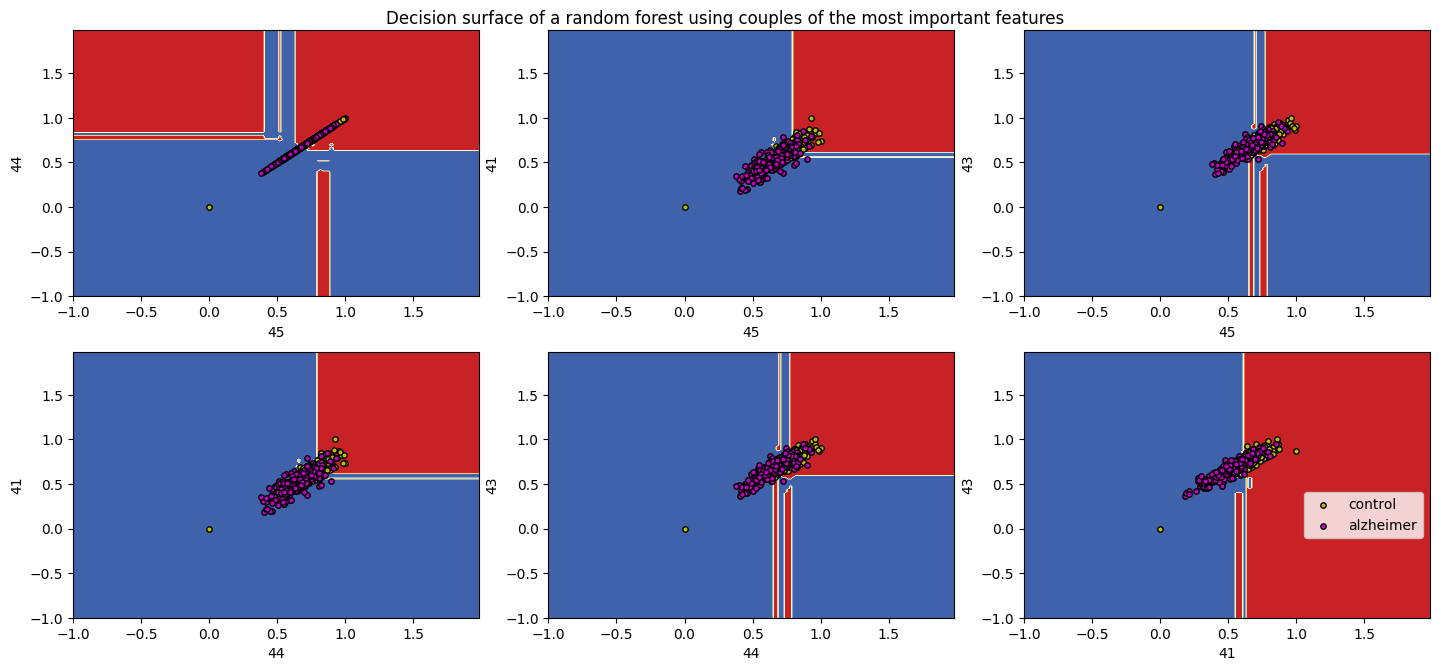

In [ ]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer**:[41, 45] and [41, 44] seems to present good results.

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

**Answers**: Even though the main biomarkers have changed, some continue to appear as amygdala and hypocampus. Also other parts like ParaHippocampus and Thalamus can be usefull i  the predictio  once they appears in more tha one dataset as important features.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

AICHA

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


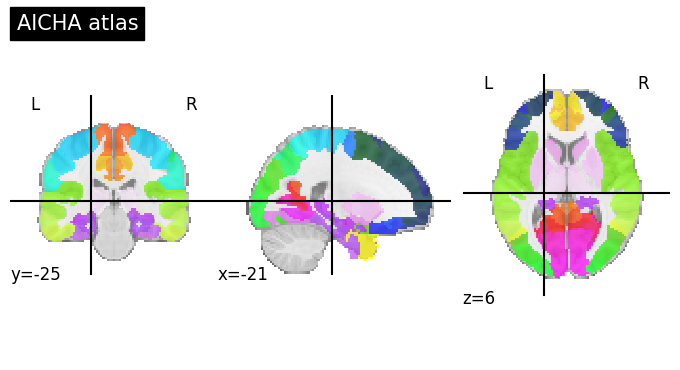

Best Validation Score: 0.7753856749311294
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 20}
Random Forest test score : 0.695364238410596
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.060072)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.054204)
3. feature 189 representing 190	N_Thalamus-7	191
 (0.027930)
4. feature 145 representing 146	S_Parietooccipital-5	147
 (0.026942)
5. feature 172 representing 173	N_Amygdala-1	174
 (0.025906)
6. feature 170 representing 171	G_Fusiform-6	172
 (0.024731)
7. feature 188 representing 189	N_Thalamus-6	190
 (0.020925)
8. feature 184 representing 185	N_Thalamus-2	186
 (0.019287)
9. feature 171 representing 172	G_Fusiform-7	173
 (0.017047)
10. feature 182 representing 183	N_Putamen-3	184
 (0.015881)


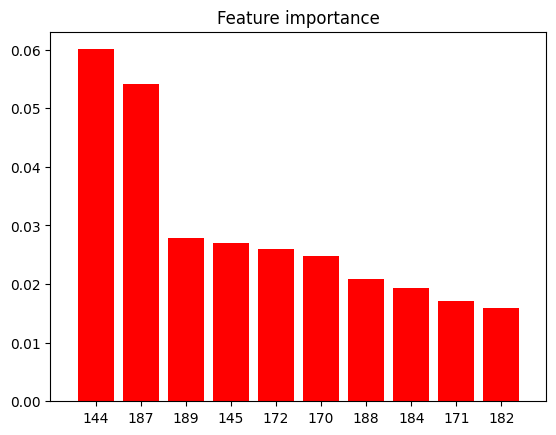

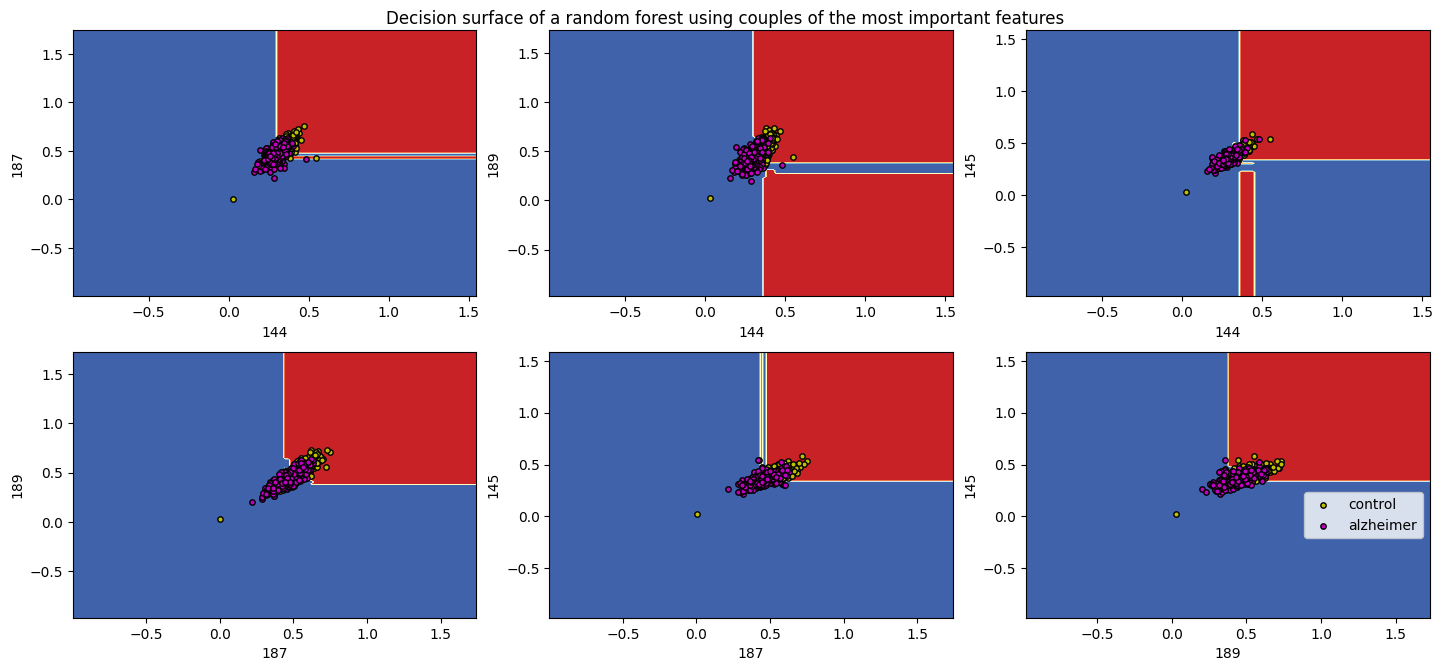

In [ ]:
X=T1AICHA
labels=ROIlabelsAICHA
atlas='./AtlasAICHA.nii'

N,M = X.shape
class_names = ["control","alzheimer"]

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title='AICHA atlas')
plotting.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit_transform(X_train, y_train);
scaler.transform(X_test);

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, cv=5, return_train_score=True)
grid_RF.fit(X_train , y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train.ravel()

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

HAMMERS

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


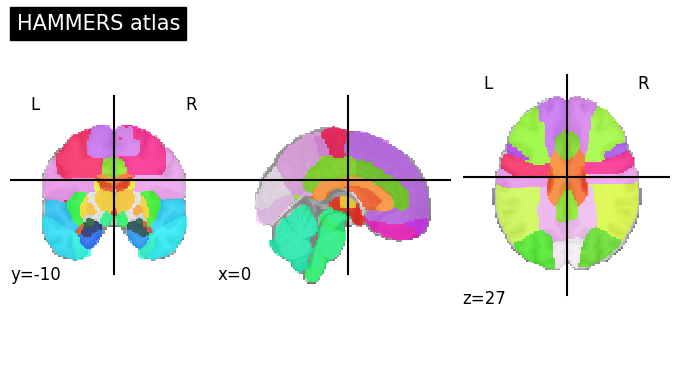

Best Validation Score: 0.8370110192837465
Best params: {'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 30}
Random Forest test score : 0.8145695364238411
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.093738)
2. feature 2 representing Left Amygdala                          (0.059521)
3. feature 0 representing Left Hippocampus                       (0.055623)
4. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.041070)
5. feature 12 representing Left Inferior Middle Temporal Gyri     (0.036867)
6. feature 46 representing Left Lateral Temporal Ventricle        (0.030330)
7. feature 5 representing Right Anterior Medial Temporal Lobe    (0.028521)
8. feature 1 representing Right Hippocampus                      (0.026373)
9. feature 4 representing Left Anterior Medial Temporal Lobe     (0.025712)
10. feature 32 representing Left Inferior Lateral Pariatal Lobe    (0.023670)


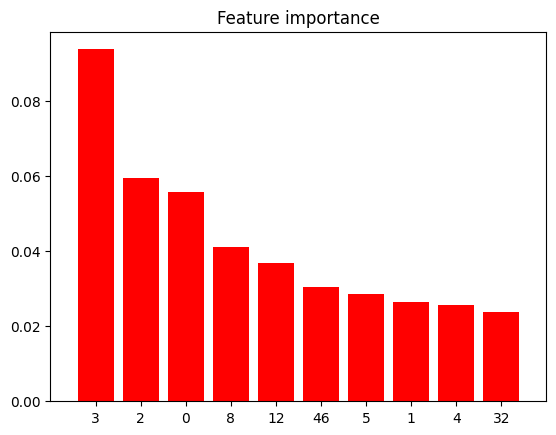

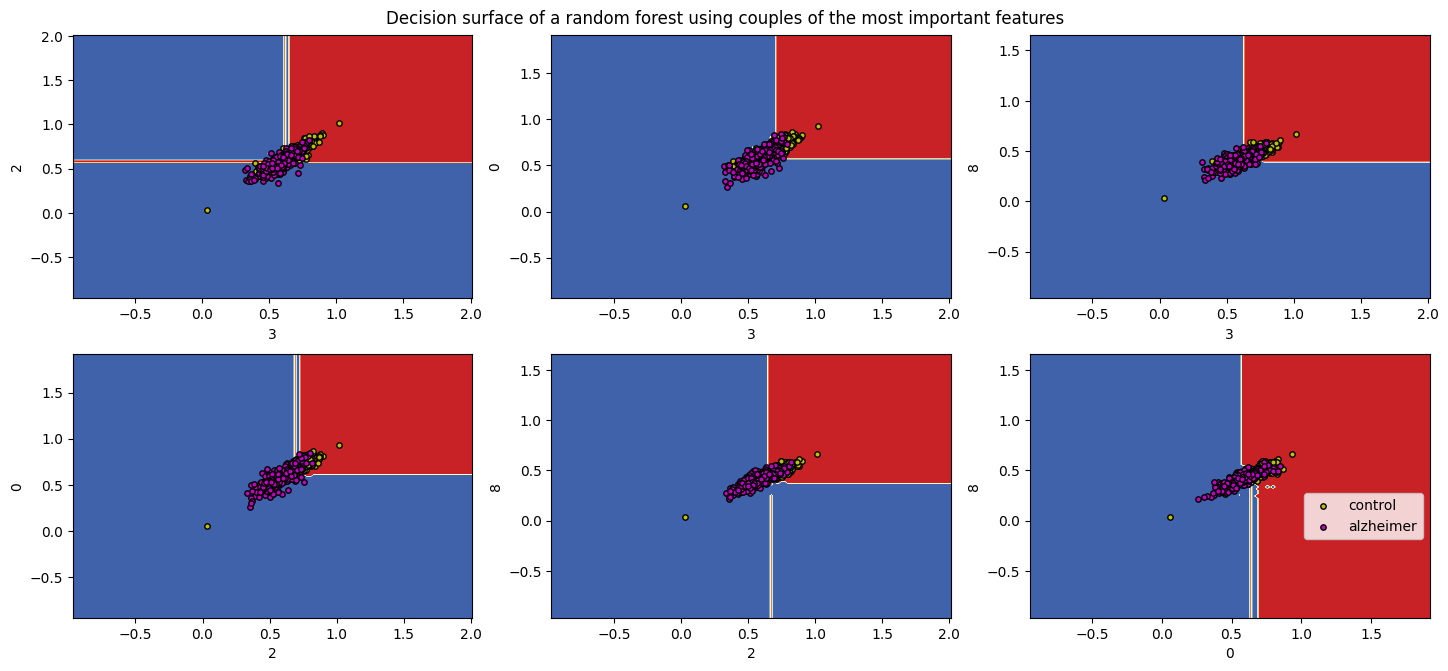

In [ ]:
X=T1HAMMERS
labels=ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii'

N,M = X.shape
class_names = ["control","alzheimer"]

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title='HAMMERS atlas')
plotting.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit_transform(X_train, y_train);
scaler.transform(X_test);

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, cv=5, return_train_score=True)
grid_RF.fit(X_train , y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train.ravel()

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()